In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

In [7]:
run.fit(3,learn)

train: [0.66982078125, tensor(0.8043)]
valid: [0.30365595703125, tensor(0.9098)]
train: [0.3036588671875, tensor(0.9111)]
valid: [0.2443218505859375, tensor(0.9302)]
train: [0.24268955078125, tensor(0.9294)]
valid: [0.2062326416015625, tensor(0.9420)]


In [8]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.76407734375, tensor(0.8004)]
valid: [0.353367626953125, tensor(0.9046)]
train: [0.3467419140625, tensor(0.9001)]
valid: [0.2876353759765625, tensor(0.9152)]
train: [0.29144423828125, tensor(0.9160)]
valid: [0.25022548828125, tensor(0.9279)]


In [9]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [10]:
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]
    
    def after_batch(self):
        if not self.in_train : return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

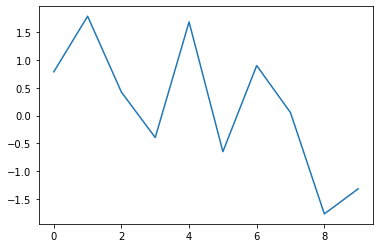

In [11]:
a = torch.randn(10)
plt.plot(a)

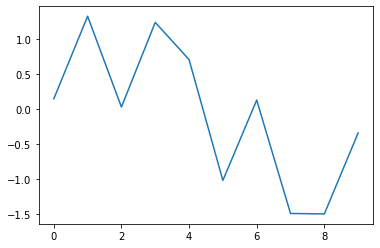

In [12]:
a = torch.randn(10)
plt.plot(a)

This is how you expect normal activations to look

In [13]:
a.mean(), a.std()

(tensor(-0.0795), tensor(1.0193))

In [14]:
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_func): self.pname, self.sched_func = pname, sched_func
    
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
    
    def begin_batch(self):
        if self.in_train: self.set_param()

In [15]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner,start,end)

In [16]:
def annealer(f):
    def _inner(start,end): return partial(f,start,end)
    return _inner

In [17]:
f = sched_lin(1,2)

In [18]:
f(0.1)

1.1

In [19]:
@annealer
def sched_lin(start,end,pos): return start + pos*(end-start)

In [20]:
f = sched_lin(1,2)

In [21]:
f(0.2)

1.2

In [22]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start,pos,end): return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [23]:
f = sched_cos(1,2)

In [24]:
f(0.4)

1.3454915028125263

In [25]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

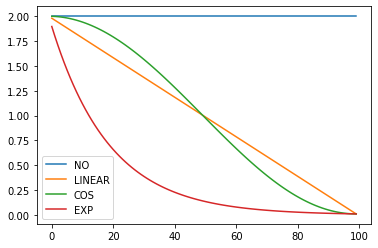

In [26]:
annealings = "NO LINEAR COS EXP".split();annealings

a = torch.arange(0,100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn,label in zip(fns,annealings):
    f = fn(2,1e-2)
    plt.plot(a,[f(o) for o in p],label=label)
plt.legend();

In [27]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    print(pcts)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        while idx < len(pcts)-1:       ### This check will be solve the bug
            actual_pos = (pos - pcts[idx]) / (pcts[idx+1] - pcts[idx])
            return scheds[idx](actual_pos.item())
    return _inner

In [28]:
pcts = [0.3, 0.7]
pcts = tensor([0] + listify(pcts))
pcts

tensor([0.0000, 0.3000, 0.7000])

In [29]:
pcts = torch.cumsum(pcts, 0); pcts

tensor([0.0000, 0.3000, 1.0000])

tensor([0.0000, 0.3000, 1.0000])


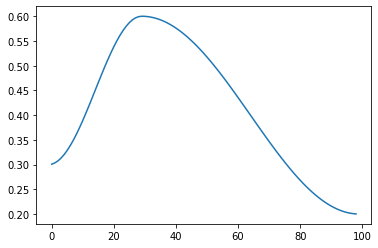

In [30]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
plt.plot(a, [sched(o) for o in p])

tensor([0.0000, 0.3000, 1.0000])


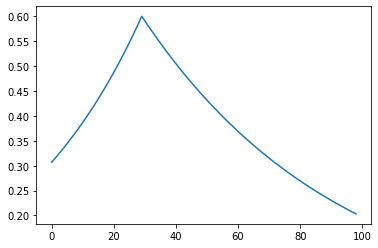

In [31]:
sched = combine_scheds([0.3, 0.7], [sched_exp(0.3, 0.6), sched_exp(0.6, 0.2)]) 
plt.plot(a, [sched(o) for o in p])

In [32]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [33]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [34]:
run.fit(2,learn)

train: [0.75501328125, tensor(0.7867)]
valid: [0.29603828125, tensor(0.9172)]
train: [0.29493955078125, tensor(0.9149)]
valid: [0.25039365234375, tensor(0.9294)]


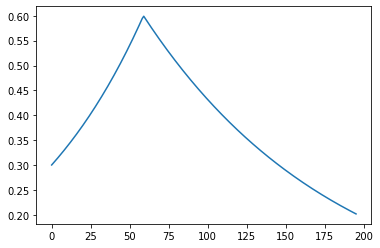

In [35]:
run.recorder.plot_lr()

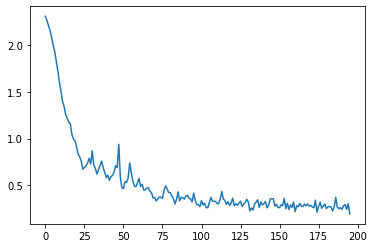

In [36]:
run.recorder.plot_loss()